## **Movie Recommendation System** - (Hybrid Recommendation ) 😎

---

### PHASE 1 - Data Exploration 


In [2]:
import pandas as pd

ratings = pd.read_csv('../data/ml-25m/ratings.csv')
movies = pd.read_csv('../data/ml-25m/movies.csv')


In [3]:
print(movies.shape)
movies.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings.shape)
ratings.head()

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
print(movies.dtypes)
print()
print(ratings.dtypes)

movieId     int64
title      object
genres     object
dtype: object

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [6]:
# Checking unique values and Sparsity of the data 

n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)
sparcity = 1 - (n_ratings / (n_movies * n_users))

print(n_users, n_movies, n_ratings, sparcity)

162541 59047 25000095 0.9973951609474271


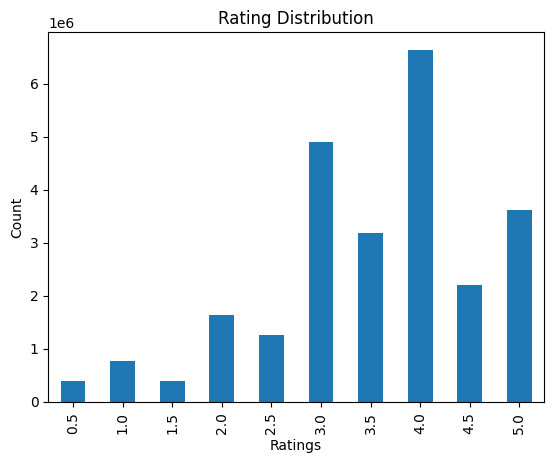

In [7]:
# Plot Rating Distribution

import matplotlib.pyplot as plt

ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()

### PHASE 2 — Baseline Recommender (START)

In [8]:
movie_stats = (
    ratings.groupby("movieId").agg(avg_rating = ("rating", "mean"), rating_count = ("rating", "count"))
)

movie_stats.head()

,avg_rating,rating_count
movieId,,
1,3.893708,57309
2,3.251527,24228
3,3.142028,11804
4,2.853547,2523
5,3.058434,11714


In [9]:
min_rating = 100

popular_movies = movie_stats[movie_stats["rating_count"] >= min_rating]

print(f"Movies with rating less than {min_rating}: {movie_stats.shape[0] - popular_movies.shape[0]}")
print("Movies before filtering:", movie_stats.shape[0])
print(f"Movies after filtering: {popular_movies.shape[0]}")

Movies with rating less than 100: 48721
Movies before filtering: 59047
Movies after filtering: 10326


In [10]:
top_movies = (
    popular_movies.sort_values(by="avg_rating", ascending=False).head(10)
)

top_movies

,avg_rating,rating_count
movieId,,
171011,4.483096,1124
159817,4.464797,1747
318,4.413576,81482
170705,4.398599,1356
171495,4.326715,277
858,4.324336,52498
179135,4.289833,659
50,4.284353,55366
198185,4.267361,288


In [11]:
top_movies_with_title = (
    top_movies.merge(movies, on="movieId")[["title", "avg_rating", "rating_count"]]
)

top_movies_with_title

,title,avg_rating,rating_count
0,Planet Earth II (2016),4.483096,1124
1,Planet Earth (2006),4.464797,1747
2,"Shawshank Redemption, The (1994)",4.413576,81482
3,Band of Brothers (2001),4.398599,1356
4,Cosmos,4.326715,277
5,"Godfather, The (1972)",4.324336,52498
6,Blue Planet II (2017),4.289833,659
7,"Usual Suspects, The (1995)",4.284353,55366
8,Twin Peaks (1989),4.267361,288
9,"Godfather: Part II, The (1974)",4.261759,34188


### PHASE 3 - Collaborative Filtering (SVD)

In [12]:
from surprise import Dataset, Reader 
import pandas as pd

# Sampling 1 Million dataset for faster training 
ratings_sample = ratings.sample(n=10_00_000, random_state=42)

reader = Reader(rating_scale = (1.5, 5))
data = Dataset.load_from_df(
    ratings_sample[["userId", "movieId", "rating"]],
    reader
)

print("Sample ratings:", ratings_sample.shape)

Sample ratings: (1000000, 4)


In [14]:
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

train, test = train_test_split(data, test_size=0.2, random_state=42)
model = SVD(random_state=42)
model.fit(train)
prediction = model.test(test)

rmse = accuracy.rmse(prediction)

RMSE: 0.9164


In [24]:
# Top-N Recommendations

def recommend_movies_svd(user_id, model, ratings_df, movies_df, n=10):
    # Movies already rated by the user
    rated_movies = set(ratings_df[ratings_df["userId"] == user_id]["movieId"])

    # Candidate movies = not yet rated
    all_movies = movies_df["movieId"].unique()
    candidates = [m for m in all_movies if m not in rated_movies]

    # (movie_id, predicted_rating) - tuples for all candidate movies.
    predictions = [
        (movie_id, model.predict(user_id, movie_id).est)
        for movie_id in candidates
    ]

    top_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]

    top_movies = (
        pd.DataFrame(top_predictions, columns=['movieId', 'predicted_rating'])
        .merge(movies_df, on='movieId')
    )

    return top_movies

In [28]:
test_user = ratings_sample["userId"].iloc[3]
print(test_user)
recommend_movies_svd(
    user_id=test_user,
    model=model,
    ratings_df=ratings_sample,
    movies_df=movies,
    n=5
)


65225


,movieId,predicted_rating,title,genres
0,260,4.709361,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,3030,4.619435,Yojimbo (1961),Action|Adventure
2,7361,4.573086,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,527,4.570082,Schindler's List (1993),Drama|War
4,318,4.546711,"Shawshank Redemption, The (1994)",Crime|Drama
